In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import patsy
import os, sys
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
%matplotlib inline

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Initial research for a Bayesian fundamental risk premia hedge fund

**Assets Traded**
-----------------
1) Equities
    - Exact breakdown is TBD
    - Categorization will either be by sector (and separated by country), or by Market Cap.
    - Or, and this may be better, by volatiltiy. This allows combining Market Cap. with Sector
    - Securities will be ETFs capturing the relecant market
2) FX
    - Categorized by developed and developing markets
3) Commodities
    - Again captured by ETFs
    - Categorization is up in the air, but potentially by hard/soft commodities
4) Fixed income
    - Natural categorization could be rating
    
**Risk Premia Used**
------------------
1) Momentum
    - Start with SMA crossover
2) Value
3) Carry

**How is this Bayseian?**
-------------------
1) At the most basic level, the idea is to infer a hierarchical regression
    - Returns ~ Indicator*a + B
    - a, B inferred from hierarchy {Asset Type} -> {Categorization} -> {Security}
2) Also interested in inferring parameters for Risk Premia calculations
    -e.g, the exact windows for the moving averages in the momentum calculation

# Step 1:
## Collect data and calculate indicators

*Initial Securities List:
Equities:
- SPY (SP500)
- EFA (Extended developed markets)
- EWJ (Japan)
- FXI (China Large-cap)
- VWO (Emerging Markets)
- IJH (SP500 Mid-cap)
- IJR (SP500 Small-cap)
- IWF (Russell 1000 Growth)
- VIG (Divided Appreciation)


Fixed Income:
- LQD (Investment Grade Corporate)
- HYG (High-yield Coroporate)
- EMB (Emerging Market Debt)
- AGG (US Debt)

Commodities:
- GLD (Gold)
- UCO (Oil)
- JO (Coffee)
- SGG (Sugar)
- PPLT (Platinum)
- VXX (Volatility)

FX:
- UUP (USD)
- FXE (EURO)
- FXB (BPS)
- FXC (CAD)
- FXA (AUD)
- FXY (JPY)
- CEW (Emerging Markets)
- BZF (BRL)

In [2]:
root_dir = os.getcwd()

In [3]:
tickers = dict(
    SPY=dict(asset='equity'),
    EWJ=dict(asset='equity'),
    FXI=dict(asset='equity'),
    EFA=dict(asset='equity'),
    VWO=dict(asset='equity'),
    IJH=dict(asset='equity'),
    IJR=dict(asset='equity'),
    IWF=dict(asset='equity'),
    VIG=dict(asset='equity'),
    LQD=dict(asset='bond'),
    HYG=dict(asset='bond'),
    EMB=dict(asset='bond'),
    AGG=dict(asset='bond'),
    GLD=dict(asset='commodity'),
    UCO=dict(asset='commodity'),
    JO=dict(asset='commodity'),
    SGG=dict(asset='commodity'),
    PPLT=dict(asset='commodity'),
#     VXX=dict(asset='commodity'),
    UUP=dict(asset='fx'),
    FXE=dict(asset='fx'),
    FXB=dict(asset='fx'),
    FXY=dict(asset='fx'),
    CEW=dict(asset='fx'),
    BZF=dict(asset='fx'),
)

In [4]:
def vol_category_helper(row, *args):
    q0, q1, q2 = args[0], args[1], args[2]
    if row <= q0:
        return 0
    elif row <= q1:
        return 1
    elif row <= q2:
        return 2
    else:
        return 3

In [5]:
def build_prices_dfs(tickers, n_categories=3):
    out = dict()
    for ticker in tickers.keys():
        df = pd.read_csv(root_dir+'/data/{}.csv'.format(ticker))
        df = df.replace({'null': np.nan})
        df['Close'] = pd.to_numeric(df['Close'])
        df['ticker'] = ticker
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        df['pct_change'] = pd.to_numeric(df['Close'].pct_change().shift(-1))
        df['log_return'] = (np.log(df.Close) - np.log(df.Close.shift(1))).shift(-1)
        df['vol'] = df['pct_change'].rolling(252).std()
        df['month_return'] = pd.to_numeric(pd.rolling_sum(df['pct_change'][::-1], window=22, min_periods=22)[::-1])
        df['month_log_return'] = pd.to_numeric(pd.rolling_sum(df['log_return'][::-1], window=22, min_periods=22)[::-1])
        df['asset_type'] = tickers[ticker]['asset']
        out[ticker] = df
    combined = pd.concat([_df for _df in out.values()])
    q1, q2, q3 = combined['vol'].quantile([.25, .5, .75])
    combined['category'] = combined['vol'].apply(vol_category_helper, args=(q1, q2, q3))
    return out, combined
        

In [6]:
prices, combined = build_prices_dfs(tickers, 3)

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False,min_periods=22).sum()
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False,min_periods=22).sum()


In [7]:
category_encodings = dict((c, i) for i, c in enumerate(combined['category'].unique()))
asset_encodings = dict((a, i) for i, a in enumerate(combined['asset_type'].unique()))
security_encodings = dict((s, i) for i, s in enumerate(combined['ticker'].unique()))

In [8]:
combined['category_enc'] = combined['category'].apply(lambda x: category_encodings[x])
combined['asset_type_enc'] = combined['asset_type'].apply(lambda x: asset_encodings[x])
combined['security_enc'] = combined['ticker'].apply(lambda x: security_encodings[x])

In [9]:
combined.groupby('ticker').mean()[['vol', 'category_enc']].sort_values('vol')

,vol,category_enc
ticker,,
AGG,0.003143,1
LQD,0.005037,1
CEW,0.005288,1
UUP,0.005639,1
FXE,0.006283,1
FXB,0.006298,1
FXY,0.006887,1
EMB,0.007078,3
HYG,0.008003,3


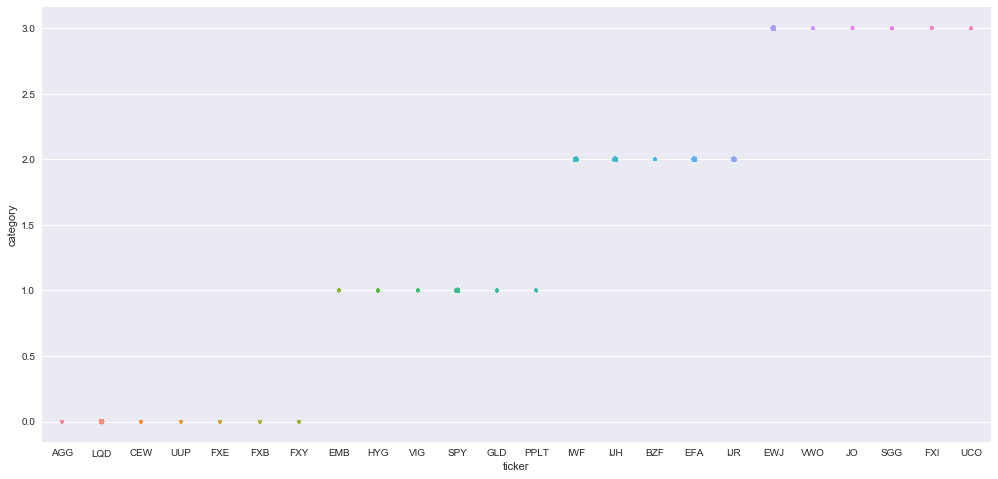

In [10]:
fig, ax = plt.subplots(figsize=(17, 8))
sns.stripplot(x='ticker', y='category', data=combined.sort_values('vol'), size=combined.sort_values('vol')['vol'].values*1000, ax=ax)
# sns.stripplot(x='ticker', y='vol', data=combined.sort_values('vol'), ax=ax)

# Step 2:
## Build hierarchical regression model

In [11]:
combined = combined.dropna()

In [12]:
combined.head()

,Open,High,Low,Close,Adj Close,Volume,ticker,pct_change,log_return,vol,month_return,month_log_return,asset_type,category,category_enc,asset_type_enc,security_enc
Date,,,,,,,,,,,,,,,,,
2000-05-26,45.687500,45.687500,45.687500,45.687500,36.954700,40000,IJH,0.038988,0.038247,0.013328,0.077453,0.074767,equity,2,0,0,0
2000-05-30,47.187500,47.468750,47.187500,47.468750,38.395473,104200,IJH,-0.001646,-0.001647,0.013328,0.043226,0.041270,equity,2,0,0,0
2000-05-31,47.390621,47.390621,47.390621,47.390621,38.332291,400,IJH,0.018134,0.017971,0.013328,0.025604,0.023461,equity,2,0,0,0
2000-06-01,47.937500,48.250000,47.937500,48.250000,39.027409,20400,IJH,0.038860,0.038124,0.013328,0.020836,0.018767,equity,2,0,0,0
2000-06-02,50.296879,50.328121,50.046879,50.125000,40.544010,83600,IJH,-0.007637,-0.007666,0.013328,-0.030578,-0.031990,equity,2,0,0,0


In [13]:
groupby = 'category_enc'
sec_category_map = (combined.groupby(['security_enc',groupby]).size()
                  .reset_index()[groupby].values)
sec_category_map

array([0, 1, 2, 1, 2, 1, 2, 0, 3, 2, 0, 1, 3, 0, 2, 1, 1, 0, 2, 3, 3, 1, 3,
       3])

In [14]:
train, test = train_test_split(combined, test_size=.3)

In [15]:
len(test)

23115

In [16]:
prices, combined = build_prices_dfs(tickers, 3)

fast_window = 7
slow_window = 25
for ticker in combined['ticker'].unique():
    combined.loc[combined['ticker'] == ticker, 'fast'] =\
    combined.loc[combined['ticker'] == ticker, 'Close'].rolling(fast_window).mean()
        
    combined.loc[combined['ticker'] == ticker, 'slow'] =\
    combined.loc[combined['ticker'] == ticker, 'Close'].rolling(slow_window).mean()
        
combined['momentum'] = pd.to_numeric((combined['fast'] - combined['slow']) / combined['slow'])
combined = combined.dropna()

category_encodings = dict((c, i) for i, c in enumerate(combined['category'].unique()))
asset_encodings = dict((a, i) for i, a in enumerate(combined['asset_type'].unique()))
security_encodings = dict((s, i) for i, s in enumerate(combined['ticker'].unique()))

combined['category_enc'] = combined['category'].apply(lambda x: category_encodings[x])
combined['asset_type_enc'] = combined['asset_type'].apply(lambda x: asset_encodings[x])
combined['security_enc'] = combined['ticker'].apply(lambda x: security_encodings[x])

groupby = 'category_enc'
sec_category_map = (combined.groupby(['security_enc',groupby]).size()
                  .reset_index()[groupby].values)
sec_category_map
n_assets = len(asset_encodings)
n_categories = len(np.unique(sec_category_map))
n_securities = len(security_encodings)

train, test = train_test_split(combined, test_size=.3)

with pm.Model() as model:
    # Hyperpriors for slope based on vol classification
    a_category_mu = pm.StudentT('a_category_mu', mu=0, sd=3, nu=1)
    a_category_sd = pm.HalfCauchy('a_category_sd', 2)
    
    # Hyperpriors for slope, derived from vol_classification, used for individual security calculation
    a_category = pm.Normal('a_category', mu=a_category_mu, sd=a_category_sd, shape=n_categories)
    a_sec_sd = pm.Uniform('a_security_sd', 1, 5)
    
    a_sec = pm.Normal('a_security', mu=a_category[sec_category_map], sd=a_sec_sd, shape=n_securities)
    
#     b_category_mu = pm.Normal('b_category_mu', mu=0, sd=1)
#     b_category_sd = pm.HalfCauchy('b_category_sd', 2)
    
#     b_category = pm.Normal('b_category', mu=b_category_mu, sd=b_category_sd, shape=n_categories)
#     b_sec_sd = pm.HalfCauchy('b_security_sd', 2)
#     b_nu = pm.Uniform('b_nu', 1, 20)
#     b_mu = pm.Normal('b_mu', mu=0, sd=2)
#     b_sd = pm.Uniform('b_sd', 1, 3)

    # Calculate the intercept for each security independently, nothing fancy here
    b_sec = pm.Uniform('b_security', -1, 1, shape=n_securities)
    
    # Forward returns ~ Indicator * slope + intercept
    y_est = (train['momentum'].values * a_sec[train['security_enc'].values] + b_sec[train['security_enc'].values])
    epsilon = pm.Uniform('epsilon', 1, 5)
    nu = pm.Uniform('nu', 1, 20)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=y_est, sd=epsilon, observed=train['month_log_return'].values)
    trace = pm.sample(300, init='advi', n_init=50000, step=pm.NUTS())

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False,min_periods=22).sum()
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False,min_periods=22).sum()
100%|██████████| 300/300 [04:42<00:00,  1.06it/s]


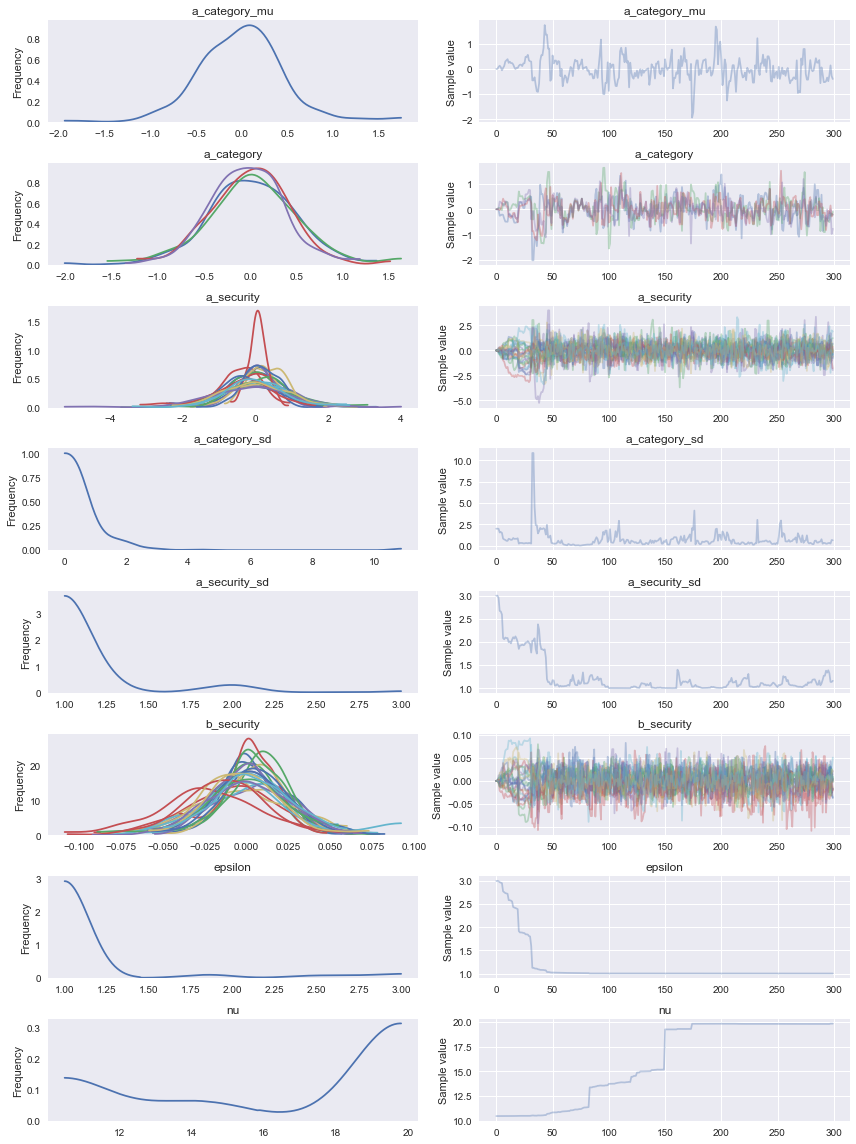

In [17]:
pm.traceplot(trace);

In [18]:
def calc_prediction_helper(row):
    rt = row.momentum * np.mean(trace['a_security'][:, row.security_enc])
#     print("{} = {} * {} + {}".format(rt, row.momentum,
#                                      np.mean(trace['a_security'][:, row.security_enc]),
#                                     np.mean(trace['b_security'][:, row.security_enc])))
    a = (row.momentum * trace['a_security'][:, row.security_enc] + trace['b_security'][:, row.security_enc])
    return np.mean(a > 0)

In [19]:
test['prediction'] = test.apply(calc_prediction_helper, axis=1)

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


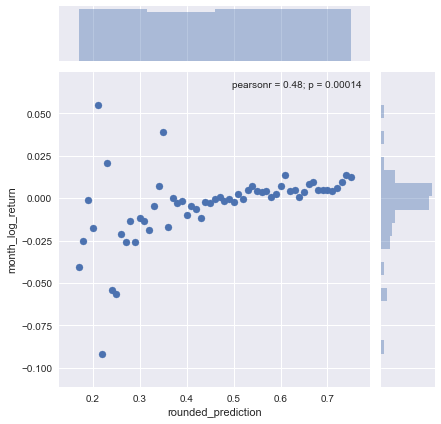

In [20]:
test['rounded_prediction'] = test['prediction'].round(2)
sns.jointplot(test.groupby('rounded_prediction').mean()['month_log_return'].index, test.groupby('rounded_prediction').mean()['month_log_return'])

In [21]:
for key, grp in test.groupby('category'):
    low, high = grp['prediction'].quantile([.25, .75])
    print('Avg. return on long positions for category {}: {}'.format(key, grp.loc[grp.prediction >= high, 'month_log_return'].mean()))
    print('Avg. return on short positions for category {}: {}\n'.format(key, grp.loc[grp.prediction <= low, 'month_log_return'].mean()))

Avg. return on long positions for category 0: 0.00040481040742863724
Avg. return on short positions for category 0: -0.001710889091295164

Avg. return on long positions for category 1: 0.0073972035006751044
Avg. return on short positions for category 1: -0.004504496588627911

Avg. return on long positions for category 2: 0.004575589809757319
Avg. return on short positions for category 2: 0.0026056154382187854

Avg. return on long positions for category 3: 0.002516550188914196
Avg. return on short positions for category 3: -0.019453132546838676



In [22]:
ticker_to_a = dict()
ticker_to_b = dict()
for t, i in security_encodings.items():
    ticker_to_a[t] = trace['a_security'][:, i]
    ticker_to_b[t] = trace['b_security'][:, i]

In [23]:
s = 'dict('
for t, a in ticker_to_a.items():
    s += t + '=['
    for x in a:
        s += str(x) + ', '
    s = s[:-2]
    s += '],'
s = s[:-1]
s += ')\n'
print(s)

dict(IJH=[0.0, 0.0, 0.00955541987244, 0.0910180186994, -0.195352423755, -0.323530567317, 0.602131978334, 0.510885387777, 0.661325155157, 0.816616351137, 0.87382622812, 1.37401693127, 1.30884830081, 1.30448453824, 1.23092169012, 0.305565574518, 0.389799201472, 0.745438613823, 0.63199292254, 0.445952311965, 0.841162628442, 0.658864250407, 0.658864250407, 0.687280794592, 0.706182311362, 0.723565570671, 0.513692698507, 0.513692698507, 0.404879889354, 0.414219241916, 0.491676356835, 0.144718070761, 0.134151851217, 0.134151851217, -0.910112229971, -0.744073770829, -0.876601887306, -0.288360882255, -0.533112144549, 0.256534264394, 0.538850148994, 0.538850148994, 0.757808990857, 0.181049484227, 0.339645846836, -0.22362532015, -0.0357488248692, -0.0357488248692, 0.105723240739, 0.215052623343, -0.695021963552, -1.437091035, 1.80875098021, 1.80875098021, 0.296120995359, 0.291190407999, -0.204670403852, -0.435050971222, -0.232390812779, 0.219951501003, -0.868390313525, -0.762680044867, -0.6722663

In [24]:
s = 'dict('
for t, a in ticker_to_b.items():
    s += t + '=['
    for x in a:
        s += str(x) + ', '
    s = s[:-2]
    s += '],'
s = s[:-1]
s += ')\n'
print(s)

dict(IJH=[0.0, 0.0, -0.00469942456576, 0.000962637216524, 0.004716018802, 0.00950760756383, -0.00664472221425, -0.012237095652, -0.0142452433202, -0.0132909600383, -0.0103221119714, -0.0105472281325, -0.00934536571834, -0.00565925167472, -0.00662736074499, -0.00314344352881, -0.004473936778, -0.00480238676686, -0.00584209925311, 0.0069969954513, 0.00763181030444, 0.00203183668796, 0.00203183668796, -0.00428946413223, -0.00761185476439, -0.0110120981213, -0.0102006062156, -0.0102006062156, -0.00925048850919, -0.0039329014184, -0.00371975476359, -0.00863767853082, -9.87483978172e-05, -9.87483978172e-05, 0.03393307836, 0.0303974954248, 0.0371155678845, -0.0212463766998, -0.00715578599508, 0.00619153586428, 0.00958648330883, 0.00958648330883, -0.00292396514734, 0.0260996083636, 0.0265115490283, 0.0134301044841, 0.0305276122794, 0.0305276122794, -0.01188342272, 0.0367262991311, -0.00144693353056, 0.00187801170513, 0.00917730920127, 0.00917730920127, 0.0326311445106, 0.0256523486964, -0.0079

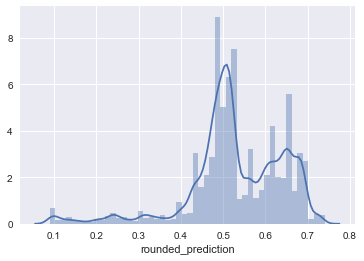

In [450]:
sns.distplot(combined['rounded_prediction'])
# sns.distplot(combined['month_log_return'])

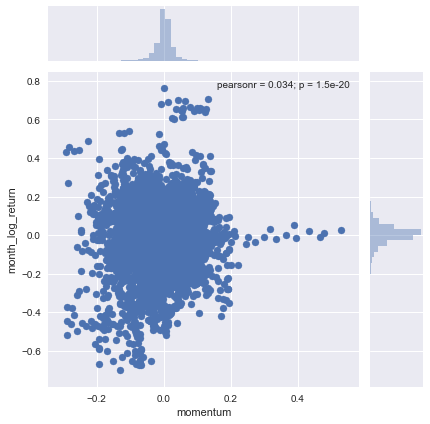

In [451]:
sns.jointplot('momentum', 'month_log_return', data=combined)

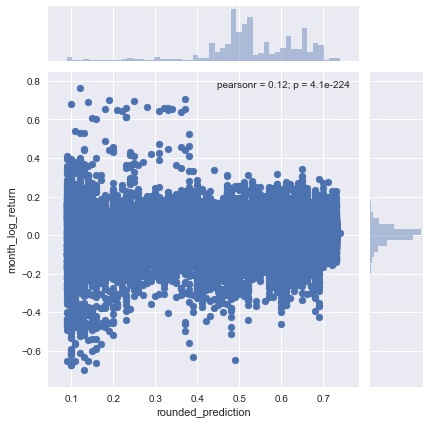

In [452]:
sns.jointplot('rounded_prediction', 'month_log_return', data=combined)

In [1]:
combined['position'] = 0
combined['position'] = np.where(combined['prediction'] >= .5, 1, 0)
combined['position'] = np.where(combined['prediction'] < .5, -1, 0)
combined['bt_return'] = combined['log_return'] * combined['position']
combined['date'] = combined.index

NameError: name 'combined' is not defined

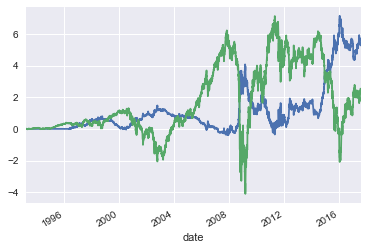

In [454]:
combined.groupby('date').sum()['bt_return'].cumsum().plot()
combined.groupby('date').sum()['log_return'].cumsum().plot()

In [318]:
# Calculate likelihood of positive forward month returns
a = (.02 * trace['a_security'][:, 10] + trace['b_security'][:, 10])
np.mean(a > 0)

0.98570000000000002

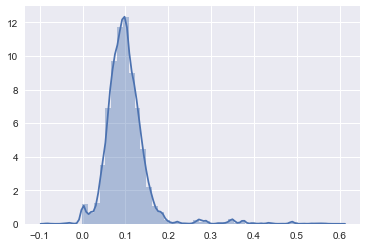

In [319]:
sns.distplot(trace['a_security'][:, 10])

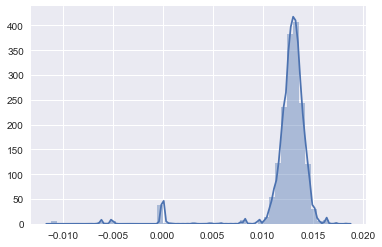

In [320]:
sns.distplot(trace['b_security'][:, 10])

In [327]:
np.mean(combined.loc[combined.security_enc==10, 'month_log_return'])

0.004074313702555441

In [168]:
security_encodings

{'AGG': 4,
 'EFA': 7,
 'EMB': 2,
 'HYG': 3,
 'IJH': 1,
 'IJR': 6,
 'IWF': 5,
 'LQD': 0,
 'SPY': 9,
 'VIG': 8,
 'VWO': 10}

In [326]:
combined.loc[:, ['momentum', 'month_log_return', 'prediction', 'security_enc']].sort_values('month_log_return')

,momentum,month_log_return,prediction,security_enc
Date,,,,
2008-09-25,-0.076662,-0.632523,0.93090,10
2008-09-24,-0.081097,-0.559686,0.91230,10
2008-09-22,-0.084976,-0.496025,0.89490,10
2008-09-25,-0.032976,-0.476216,0.97245,7
2008-09-19,-0.084898,-0.462080,0.89495,10
2008-09-25,-0.030162,-0.459665,0.97435,1
2008-09-23,-0.083429,-0.450323,0.90190,10
2008-09-26,-0.075104,-0.446928,0.93620,10
2008-09-25,-0.012921,-0.425113,0.98040,6


In [227]:
pd.DataFrame([1,2,3,4]).shift(1).rolling(3).mean()

,0
0,NaN
1,NaN
2,NaN
3,2.0
